<a href="https://colab.research.google.com/github/square-1111/Miscellaneous/blob/master/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of [Conditional GAN](https://arxiv.org/abs/1411.1784)
**Using MNIST Dataset**  

Class labels are used to condition generator and discriminator network

##Preprocessing and Basic Parameters

In [1]:
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, multiply
from keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from keras.layers import Input, Flatten, Embedding, Reshape
import numpy as np

import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)
y_train = y_train.reshape(-1,1)

In [4]:
img_rows, img_cols, channels = 28, 28, 1
img_shape = (img_rows, img_cols, channels)

num_classes = 10
latent_dim = 100

optimizer = Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


## Discriminator

In [0]:
def disc():
  discriminator = Sequential()
  discriminator.add(Dense(512, input_dim=np.prod(img_shape)))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Dropout(0.4))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Dropout(rate=0.6))

  discriminator.add(Dense(1, activation='sigmoid'))
  
  img = Input(shape=img_shape)
  label = Input(shape=(1,), dtype='int32')

  label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
  flat_img = Flatten()(img)

  dis_input = multiply([flat_img, label_embedding])
  
  validity = discriminator(dis_input)
  
  return Model([img, label], validity)

In [6]:
discriminator=disc()
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_2[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_1[0][0]               

In [0]:
discriminator.compile(loss=['binary_crossentropy'],optimizer=optimizer,
                      metrics=['accuracy'])

## Generator

In [0]:
def gen():
  generator = Sequential()

  generator.add(Dense(256, input_dim=latent_dim))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(np.prod(img_shape), activation ='tanh'))
  generator.add(Reshape(img_shape))

  noise = Input(shape=(latent_dim,))
  label = Input(shape=(1,), dtype='int32')
  label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

  gen_input = multiply([noise, label_embedding])

  gen_img = generator(gen_input)
  
  return Model([noise,label], gen_img)

In [9]:
generator = gen()
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_2

In [10]:
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
gen_img = generator([noise, label])


generator = Model([noise, label],gen_img)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    1494520     input_5[0][0]                    
                                                                 input_6[0][0]                    
Total params: 1,494,520
Trainable params: 1,490,936
Non-trainable params: 3,584
__________________________________________________________________________________________________


In [0]:
discriminator.trainable = False

In [0]:
valid = discriminator([gen_img, label])

In [13]:
gan = Model([noise, label], valid)
gan.compile(loss=['binary_crossentropy'],optimizer=optimizer)
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    1494520     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            935585      model_2[1][0]                    
          

## Train

In [0]:
!rm -rf GAN_output/

In [0]:
batch_size = 32
epochs = 20000

os.mkdir("GAN_output")

In [0]:
valid = np.ones((batch_size,1))
fake = np.zeros((batch_size,1))

In [0]:
def sample_images(step):
  r, c = 2, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  sampled_labels = np.arange(0, 10).reshape(-1, 1)

  gen_imgs = generator.predict([noise, sampled_labels])

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
          axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
          axs[i,j].axis('off')
          cnt += 1
  print(gen_imgs.shape)
  plt.show()
  plt.close()

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696147, acc.: 20.31%] [G loss: 0.687240]
(10, 28, 28, 1)


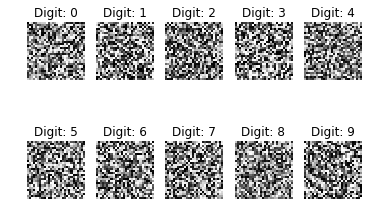

100 [D loss: 0.318442, acc.: 89.06%] [G loss: 6.850874]
(10, 28, 28, 1)


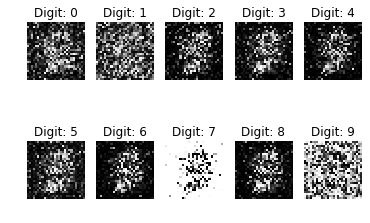

200 [D loss: 0.321887, acc.: 87.50%] [G loss: 4.297657]
(10, 28, 28, 1)


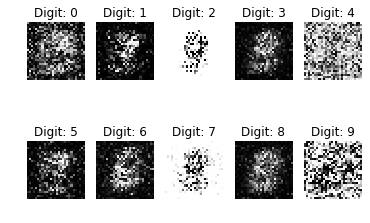

300 [D loss: 0.545767, acc.: 73.44%] [G loss: 2.729255]
(10, 28, 28, 1)


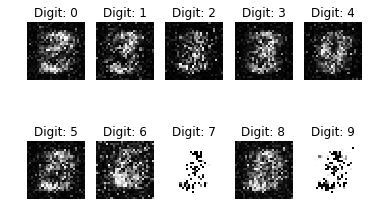

400 [D loss: 0.541099, acc.: 73.44%] [G loss: 1.699293]
(10, 28, 28, 1)


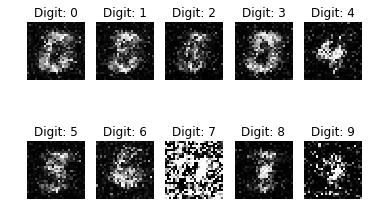

500 [D loss: 0.600326, acc.: 64.06%] [G loss: 1.312555]
(10, 28, 28, 1)


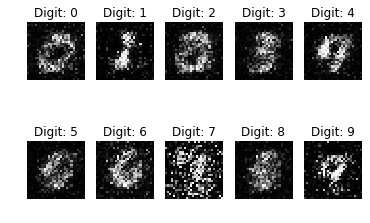

600 [D loss: 0.505953, acc.: 78.12%] [G loss: 1.356318]
(10, 28, 28, 1)


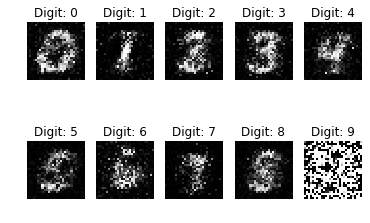

700 [D loss: 0.658675, acc.: 59.38%] [G loss: 1.514978]
(10, 28, 28, 1)


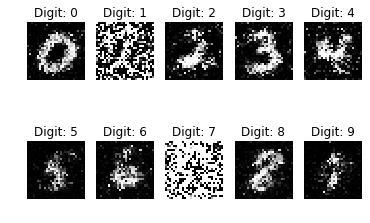

800 [D loss: 0.568112, acc.: 73.44%] [G loss: 1.286514]
(10, 28, 28, 1)


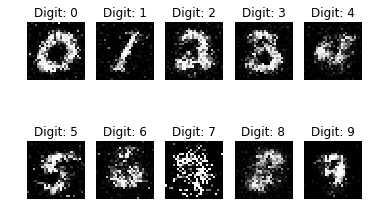

900 [D loss: 0.525448, acc.: 78.12%] [G loss: 1.103486]
(10, 28, 28, 1)


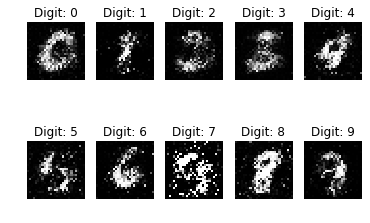

1000 [D loss: 0.708041, acc.: 59.38%] [G loss: 0.962269]
(10, 28, 28, 1)


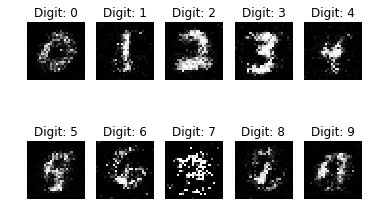

1100 [D loss: 0.661148, acc.: 59.38%] [G loss: 0.908440]
(10, 28, 28, 1)


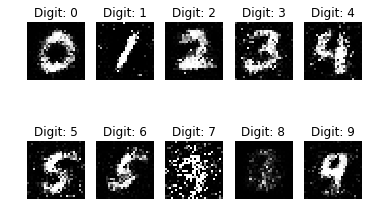

1200 [D loss: 0.642802, acc.: 56.25%] [G loss: 0.915458]
(10, 28, 28, 1)


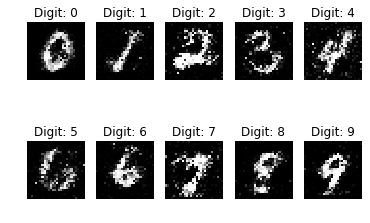

1300 [D loss: 0.654887, acc.: 60.94%] [G loss: 0.928813]
(10, 28, 28, 1)


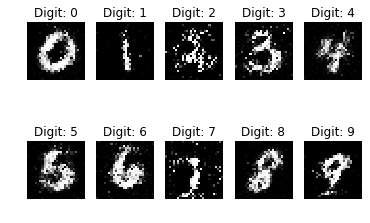

1400 [D loss: 0.659135, acc.: 62.50%] [G loss: 0.983680]
(10, 28, 28, 1)


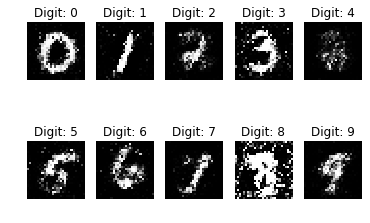

1500 [D loss: 0.664379, acc.: 57.81%] [G loss: 0.903189]
(10, 28, 28, 1)


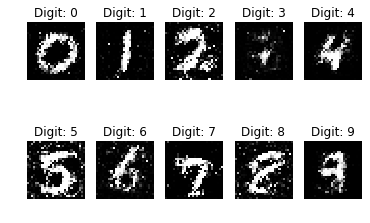

1600 [D loss: 0.625504, acc.: 59.38%] [G loss: 0.875383]
(10, 28, 28, 1)


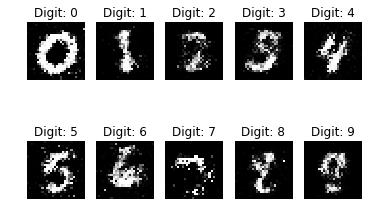

1700 [D loss: 0.672096, acc.: 56.25%] [G loss: 0.989105]
(10, 28, 28, 1)


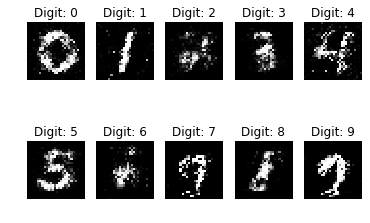

1800 [D loss: 0.665891, acc.: 53.12%] [G loss: 0.936321]
(10, 28, 28, 1)


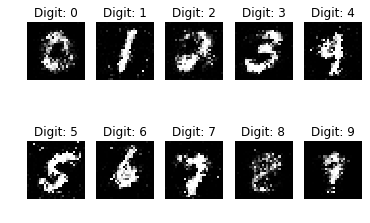

1900 [D loss: 0.701199, acc.: 50.00%] [G loss: 0.986562]
(10, 28, 28, 1)


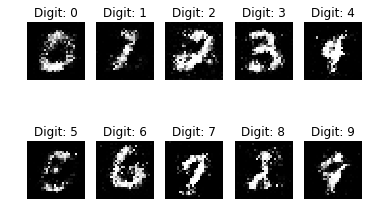

2000 [D loss: 0.638814, acc.: 62.50%] [G loss: 0.991734]
(10, 28, 28, 1)


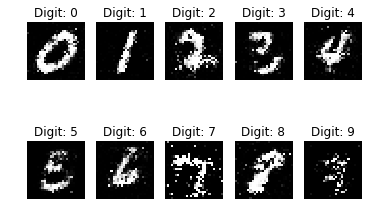

2100 [D loss: 0.675020, acc.: 59.38%] [G loss: 0.881699]
(10, 28, 28, 1)


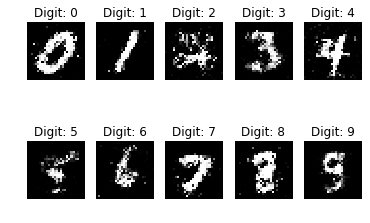

2200 [D loss: 0.636013, acc.: 64.06%] [G loss: 1.034341]
(10, 28, 28, 1)


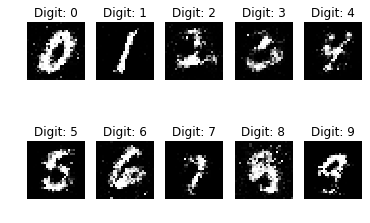

2300 [D loss: 0.666360, acc.: 59.38%] [G loss: 0.884090]
(10, 28, 28, 1)


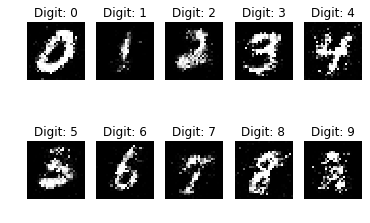

2400 [D loss: 0.662968, acc.: 56.25%] [G loss: 0.891802]
(10, 28, 28, 1)


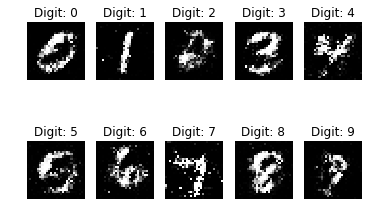

2500 [D loss: 0.694779, acc.: 56.25%] [G loss: 0.988367]
(10, 28, 28, 1)


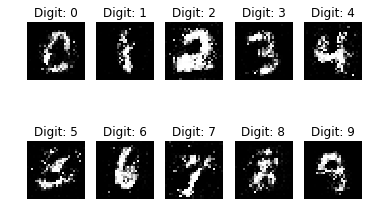

2600 [D loss: 0.652851, acc.: 57.81%] [G loss: 0.952521]
(10, 28, 28, 1)


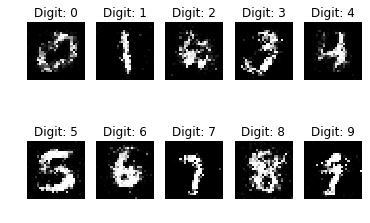

2700 [D loss: 0.630123, acc.: 68.75%] [G loss: 0.892800]
(10, 28, 28, 1)


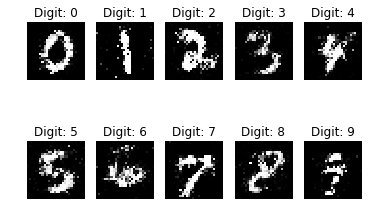

2800 [D loss: 0.612395, acc.: 65.62%] [G loss: 0.842561]
(10, 28, 28, 1)


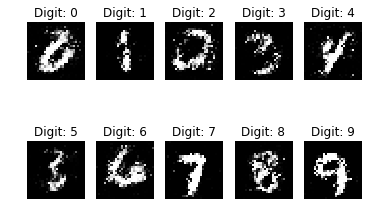

2900 [D loss: 0.691796, acc.: 53.12%] [G loss: 0.823962]
(10, 28, 28, 1)


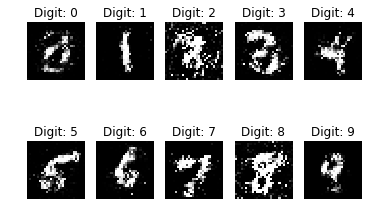

3000 [D loss: 0.664057, acc.: 50.00%] [G loss: 0.864921]
(10, 28, 28, 1)


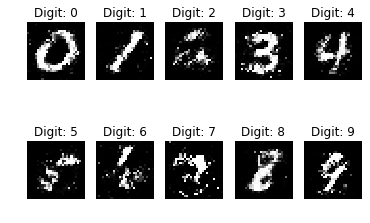

3100 [D loss: 0.655078, acc.: 62.50%] [G loss: 0.811452]
(10, 28, 28, 1)


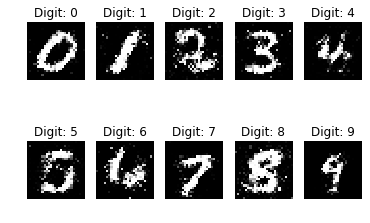

3200 [D loss: 0.687355, acc.: 62.50%] [G loss: 0.835129]
(10, 28, 28, 1)


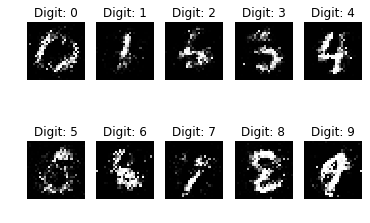

3300 [D loss: 0.687436, acc.: 57.81%] [G loss: 0.857824]
(10, 28, 28, 1)


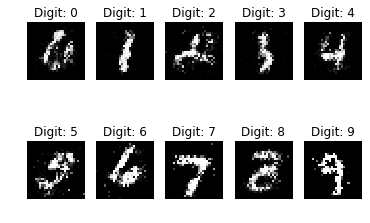

3400 [D loss: 0.678496, acc.: 59.38%] [G loss: 0.850856]
(10, 28, 28, 1)


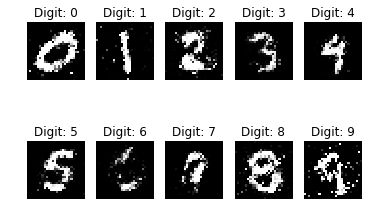

3500 [D loss: 0.680495, acc.: 56.25%] [G loss: 0.847484]
(10, 28, 28, 1)


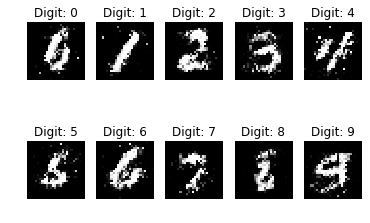

3600 [D loss: 0.631601, acc.: 62.50%] [G loss: 0.844535]
(10, 28, 28, 1)


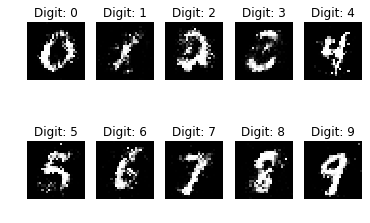

3700 [D loss: 0.726398, acc.: 50.00%] [G loss: 0.839929]
(10, 28, 28, 1)


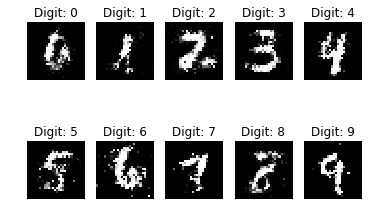

3800 [D loss: 0.640992, acc.: 65.62%] [G loss: 0.859946]
(10, 28, 28, 1)


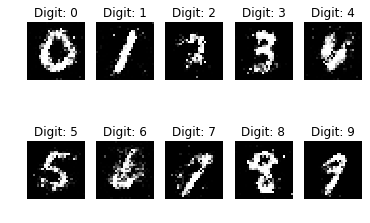

3900 [D loss: 0.675273, acc.: 59.38%] [G loss: 0.815984]
(10, 28, 28, 1)


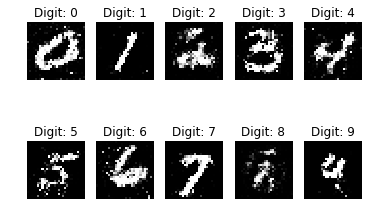

4000 [D loss: 0.652987, acc.: 62.50%] [G loss: 0.807972]
(10, 28, 28, 1)


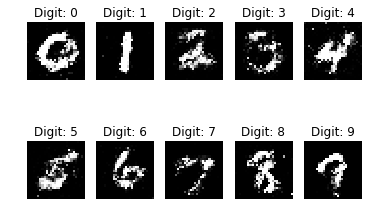

4100 [D loss: 0.680197, acc.: 54.69%] [G loss: 0.829705]
(10, 28, 28, 1)


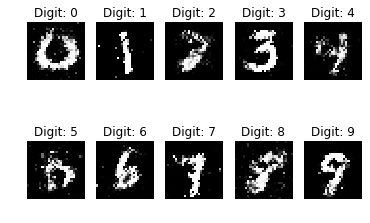

4200 [D loss: 0.706461, acc.: 51.56%] [G loss: 0.861571]
(10, 28, 28, 1)


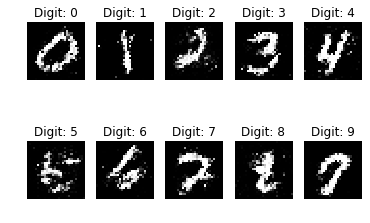

4300 [D loss: 0.665963, acc.: 51.56%] [G loss: 0.772553]
(10, 28, 28, 1)


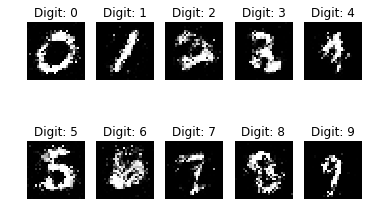

4400 [D loss: 0.634351, acc.: 64.06%] [G loss: 0.813599]
(10, 28, 28, 1)


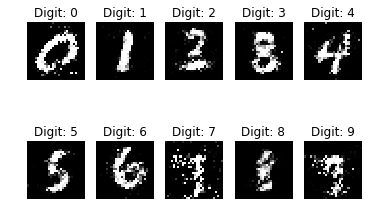

4500 [D loss: 0.649165, acc.: 59.38%] [G loss: 0.777324]
(10, 28, 28, 1)


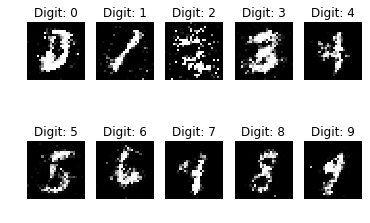

4600 [D loss: 0.684048, acc.: 42.19%] [G loss: 0.817817]
(10, 28, 28, 1)


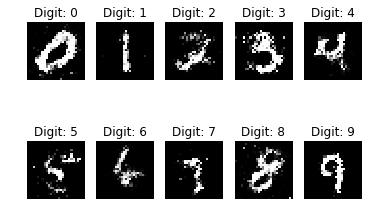

4700 [D loss: 0.652027, acc.: 57.81%] [G loss: 0.794534]
(10, 28, 28, 1)


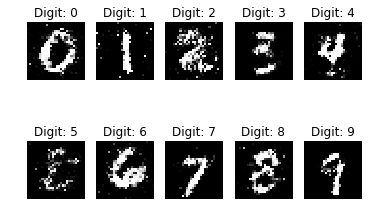

4800 [D loss: 0.631560, acc.: 64.06%] [G loss: 0.753363]
(10, 28, 28, 1)


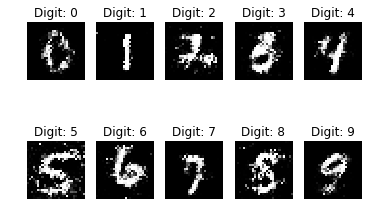

4900 [D loss: 0.674287, acc.: 62.50%] [G loss: 0.769822]
(10, 28, 28, 1)


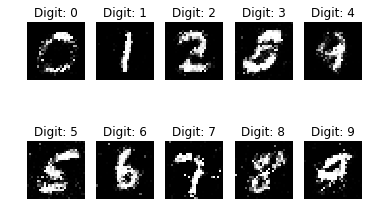

5000 [D loss: 0.662697, acc.: 70.31%] [G loss: 0.759837]
(10, 28, 28, 1)


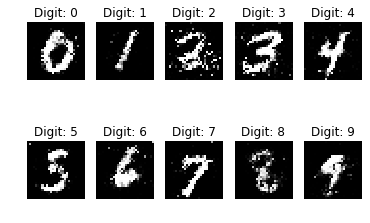

5100 [D loss: 0.701128, acc.: 59.38%] [G loss: 0.856858]
(10, 28, 28, 1)


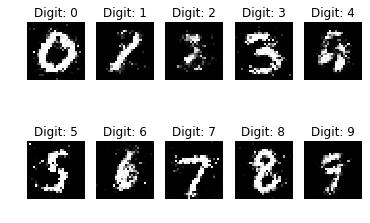

5200 [D loss: 0.621602, acc.: 65.62%] [G loss: 0.879457]
(10, 28, 28, 1)


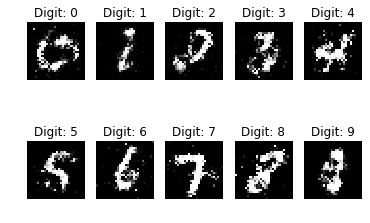

5300 [D loss: 0.685333, acc.: 48.44%] [G loss: 0.798489]
(10, 28, 28, 1)


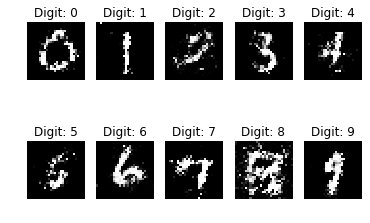

5400 [D loss: 0.740313, acc.: 59.38%] [G loss: 0.801077]
(10, 28, 28, 1)


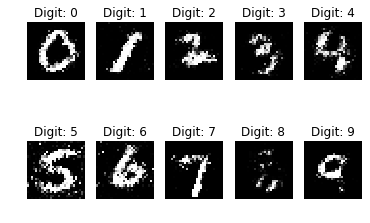

5500 [D loss: 0.643110, acc.: 67.19%] [G loss: 0.796741]
(10, 28, 28, 1)


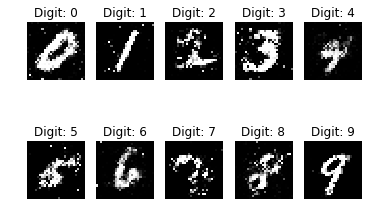

5600 [D loss: 0.670959, acc.: 56.25%] [G loss: 0.749595]
(10, 28, 28, 1)


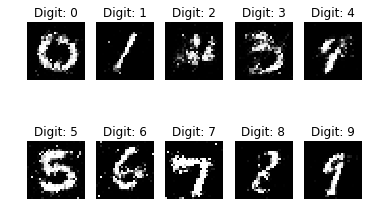

5700 [D loss: 0.705915, acc.: 54.69%] [G loss: 0.811769]
(10, 28, 28, 1)


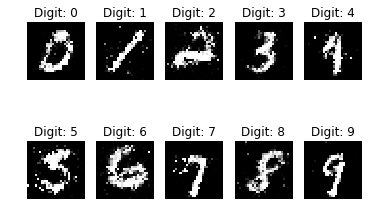

5800 [D loss: 0.712220, acc.: 50.00%] [G loss: 0.769769]
(10, 28, 28, 1)


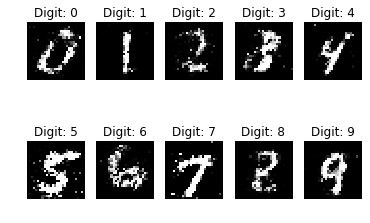

5900 [D loss: 0.699496, acc.: 50.00%] [G loss: 0.805037]
(10, 28, 28, 1)


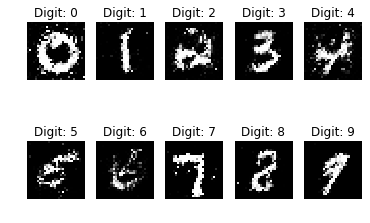

6000 [D loss: 0.680180, acc.: 60.94%] [G loss: 0.745289]
(10, 28, 28, 1)


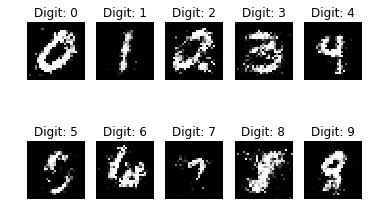

6100 [D loss: 0.734051, acc.: 42.19%] [G loss: 0.751127]
(10, 28, 28, 1)


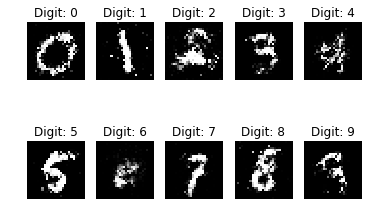

6200 [D loss: 0.643274, acc.: 56.25%] [G loss: 0.829775]
(10, 28, 28, 1)


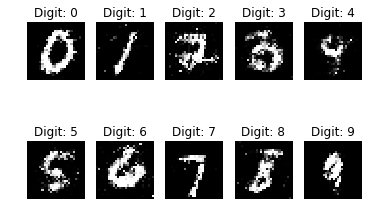

6300 [D loss: 0.674133, acc.: 53.12%] [G loss: 0.793769]
(10, 28, 28, 1)


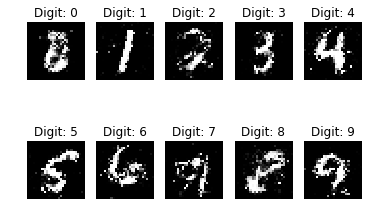

6400 [D loss: 0.652978, acc.: 53.12%] [G loss: 0.764116]
(10, 28, 28, 1)


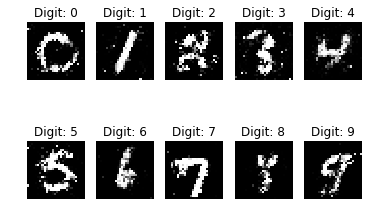

6500 [D loss: 0.656292, acc.: 67.19%] [G loss: 0.764718]
(10, 28, 28, 1)


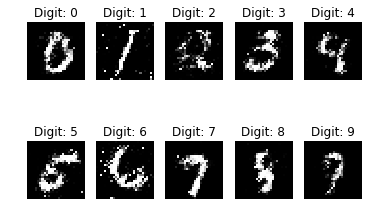

6600 [D loss: 0.690767, acc.: 54.69%] [G loss: 0.815805]
(10, 28, 28, 1)


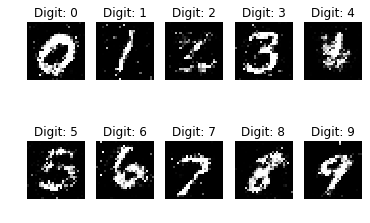

6700 [D loss: 0.662620, acc.: 62.50%] [G loss: 0.763530]
(10, 28, 28, 1)


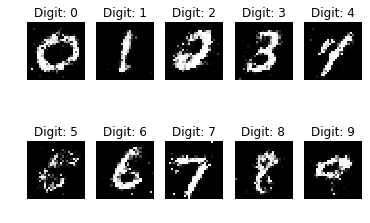

6800 [D loss: 0.650805, acc.: 59.38%] [G loss: 0.800916]
(10, 28, 28, 1)


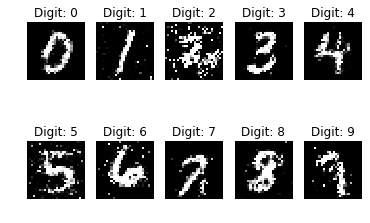

6900 [D loss: 0.655499, acc.: 60.94%] [G loss: 0.721916]
(10, 28, 28, 1)


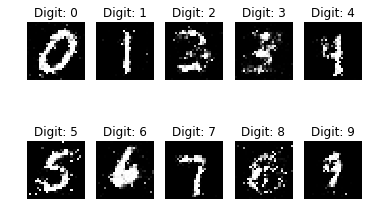

7000 [D loss: 0.635958, acc.: 64.06%] [G loss: 0.800375]
(10, 28, 28, 1)


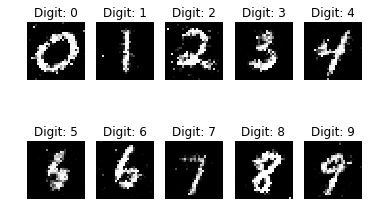

7100 [D loss: 0.709690, acc.: 51.56%] [G loss: 0.748483]
(10, 28, 28, 1)


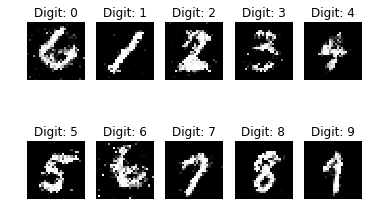

7200 [D loss: 0.662657, acc.: 59.38%] [G loss: 0.819838]
(10, 28, 28, 1)


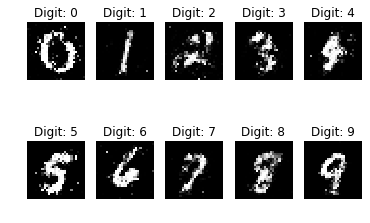

7300 [D loss: 0.687807, acc.: 59.38%] [G loss: 0.786688]
(10, 28, 28, 1)


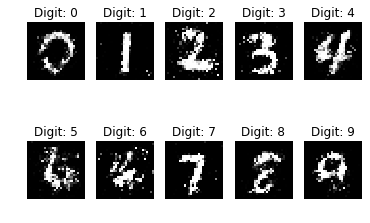

7400 [D loss: 0.654427, acc.: 54.69%] [G loss: 0.790125]
(10, 28, 28, 1)


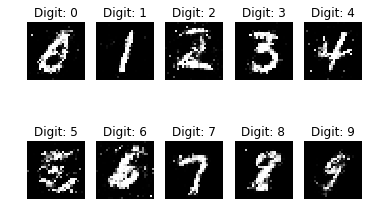

7500 [D loss: 0.686338, acc.: 56.25%] [G loss: 0.883504]
(10, 28, 28, 1)


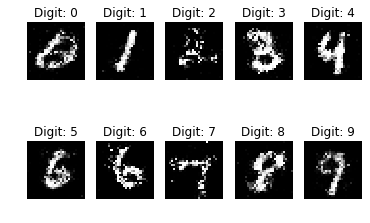

7600 [D loss: 0.677987, acc.: 51.56%] [G loss: 0.801271]
(10, 28, 28, 1)


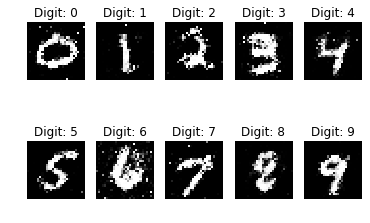

7700 [D loss: 0.633222, acc.: 67.19%] [G loss: 0.763453]
(10, 28, 28, 1)


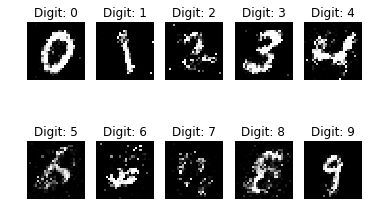

7800 [D loss: 0.667530, acc.: 60.94%] [G loss: 0.791556]
(10, 28, 28, 1)


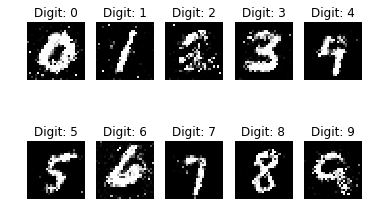

7900 [D loss: 0.672580, acc.: 59.38%] [G loss: 0.806318]
(10, 28, 28, 1)


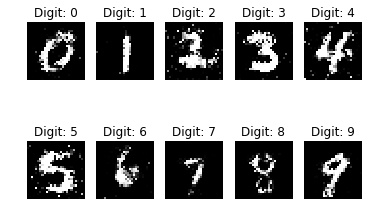

8000 [D loss: 0.726874, acc.: 51.56%] [G loss: 0.881205]
(10, 28, 28, 1)


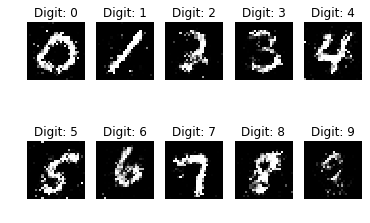

8100 [D loss: 0.664850, acc.: 51.56%] [G loss: 0.798778]
(10, 28, 28, 1)


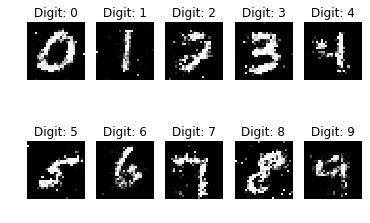

8200 [D loss: 0.627533, acc.: 65.62%] [G loss: 0.731970]
(10, 28, 28, 1)


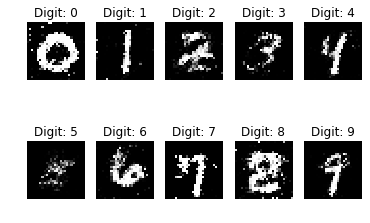

8300 [D loss: 0.649130, acc.: 57.81%] [G loss: 0.769835]
(10, 28, 28, 1)


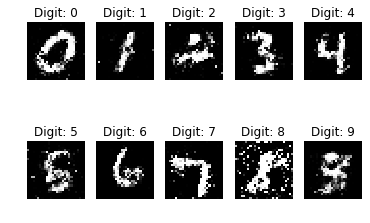

8400 [D loss: 0.675656, acc.: 53.12%] [G loss: 0.783907]
(10, 28, 28, 1)


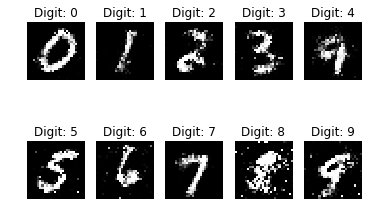

8500 [D loss: 0.679283, acc.: 53.12%] [G loss: 0.843607]
(10, 28, 28, 1)


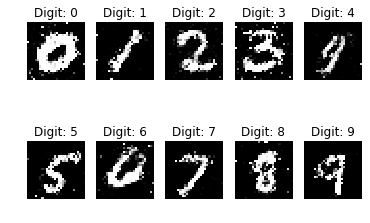

8600 [D loss: 0.643494, acc.: 65.62%] [G loss: 0.788878]
(10, 28, 28, 1)


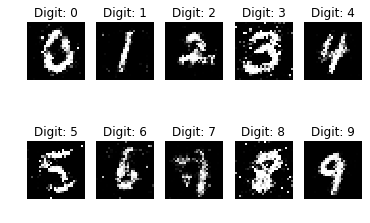

8700 [D loss: 0.635293, acc.: 56.25%] [G loss: 0.751535]
(10, 28, 28, 1)


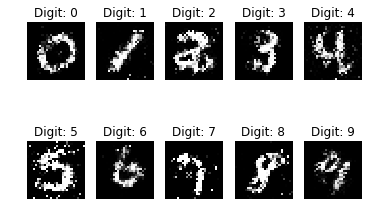

8800 [D loss: 0.692652, acc.: 54.69%] [G loss: 0.765486]
(10, 28, 28, 1)


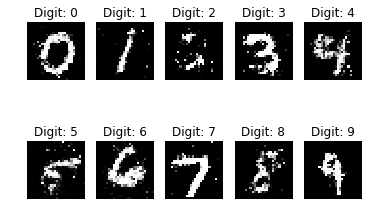

8900 [D loss: 0.660843, acc.: 56.25%] [G loss: 0.785259]
(10, 28, 28, 1)


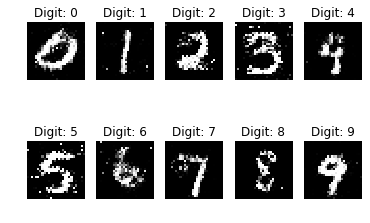

9000 [D loss: 0.635288, acc.: 67.19%] [G loss: 0.755693]
(10, 28, 28, 1)


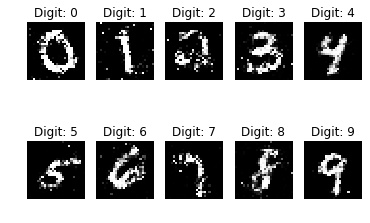

9100 [D loss: 0.664503, acc.: 60.94%] [G loss: 0.801836]
(10, 28, 28, 1)


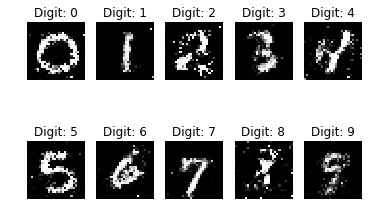

9200 [D loss: 0.662925, acc.: 56.25%] [G loss: 0.774462]
(10, 28, 28, 1)


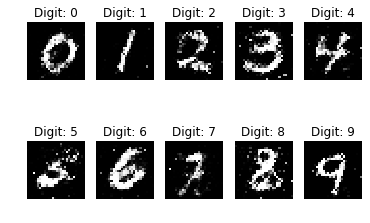

9300 [D loss: 0.699219, acc.: 57.81%] [G loss: 0.810928]
(10, 28, 28, 1)


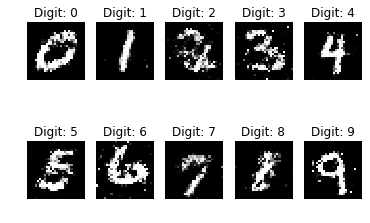

9400 [D loss: 0.690613, acc.: 50.00%] [G loss: 0.861105]
(10, 28, 28, 1)


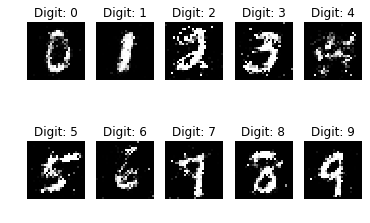

9500 [D loss: 0.690918, acc.: 54.69%] [G loss: 0.799842]
(10, 28, 28, 1)


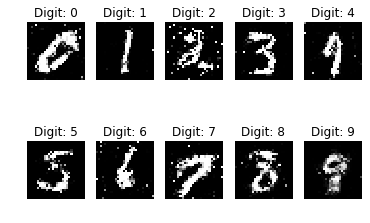

9600 [D loss: 0.687693, acc.: 51.56%] [G loss: 0.784707]
(10, 28, 28, 1)


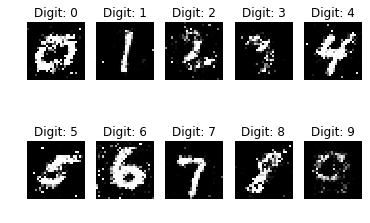

9700 [D loss: 0.687287, acc.: 62.50%] [G loss: 0.803873]
(10, 28, 28, 1)


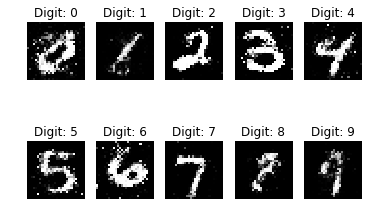

9800 [D loss: 0.638682, acc.: 60.94%] [G loss: 0.830582]
(10, 28, 28, 1)


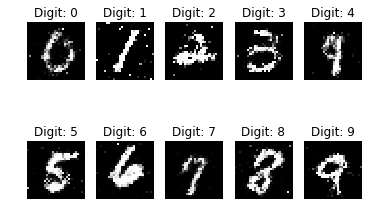

9900 [D loss: 0.643582, acc.: 59.38%] [G loss: 0.761840]
(10, 28, 28, 1)


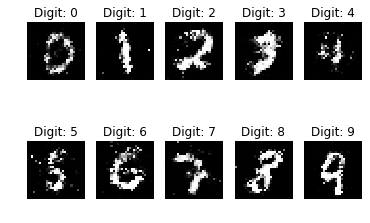

10000 [D loss: 0.665593, acc.: 53.12%] [G loss: 0.744766]
(10, 28, 28, 1)


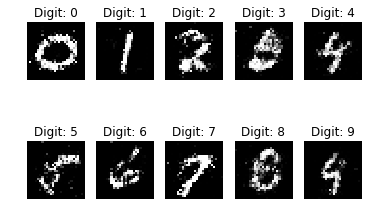

10100 [D loss: 0.656365, acc.: 60.94%] [G loss: 0.812812]
(10, 28, 28, 1)


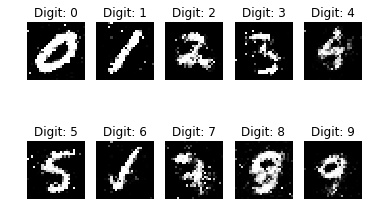

10200 [D loss: 0.630423, acc.: 62.50%] [G loss: 0.808223]
(10, 28, 28, 1)


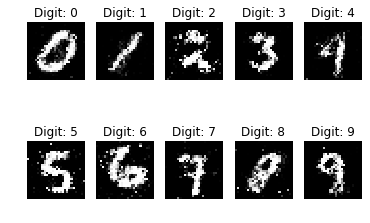

10300 [D loss: 0.732709, acc.: 50.00%] [G loss: 0.836883]
(10, 28, 28, 1)


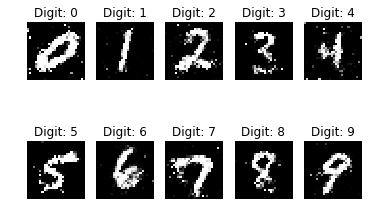

10400 [D loss: 0.672572, acc.: 59.38%] [G loss: 0.792759]
(10, 28, 28, 1)


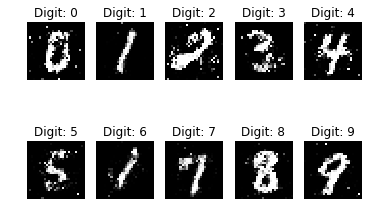

10500 [D loss: 0.678137, acc.: 50.00%] [G loss: 0.833038]
(10, 28, 28, 1)


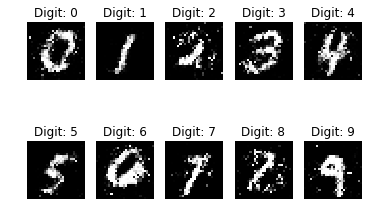

10600 [D loss: 0.681979, acc.: 53.12%] [G loss: 0.789583]
(10, 28, 28, 1)


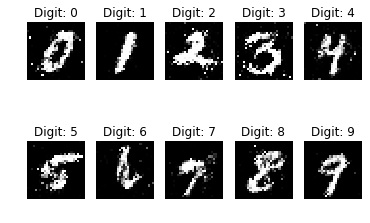

10700 [D loss: 0.693240, acc.: 54.69%] [G loss: 0.854573]
(10, 28, 28, 1)


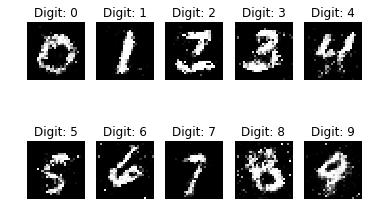

10800 [D loss: 0.670106, acc.: 48.44%] [G loss: 0.810193]
(10, 28, 28, 1)


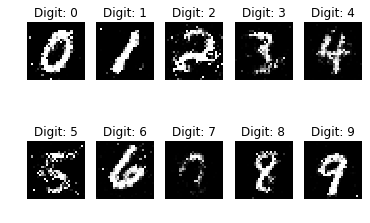

10900 [D loss: 0.634128, acc.: 57.81%] [G loss: 0.813735]
(10, 28, 28, 1)


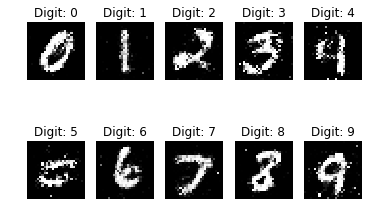

11000 [D loss: 0.682738, acc.: 56.25%] [G loss: 0.777867]
(10, 28, 28, 1)


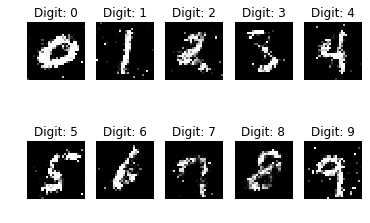

11100 [D loss: 0.677512, acc.: 53.12%] [G loss: 0.798251]
(10, 28, 28, 1)


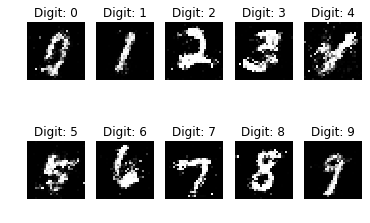

11200 [D loss: 0.699755, acc.: 56.25%] [G loss: 0.853914]
(10, 28, 28, 1)


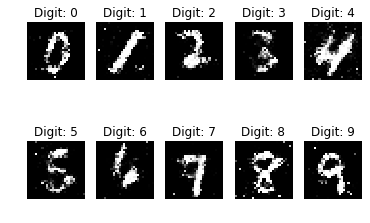

11300 [D loss: 0.667182, acc.: 56.25%] [G loss: 0.751755]
(10, 28, 28, 1)


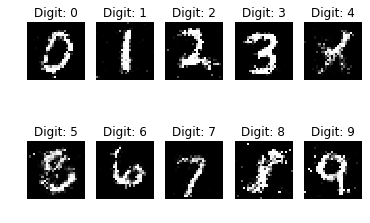

11400 [D loss: 0.714392, acc.: 50.00%] [G loss: 0.756681]
(10, 28, 28, 1)


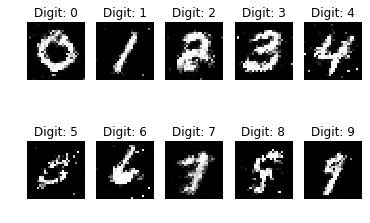

11500 [D loss: 0.654552, acc.: 59.38%] [G loss: 0.853523]
(10, 28, 28, 1)


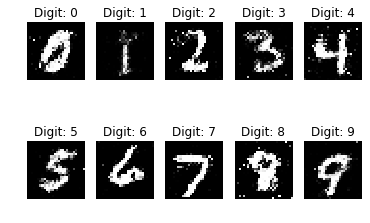

11600 [D loss: 0.686972, acc.: 57.81%] [G loss: 0.813209]
(10, 28, 28, 1)


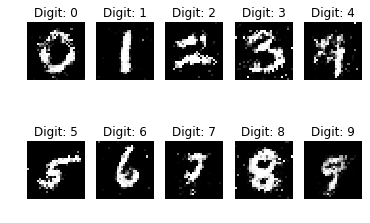

11700 [D loss: 0.687214, acc.: 50.00%] [G loss: 0.792547]
(10, 28, 28, 1)


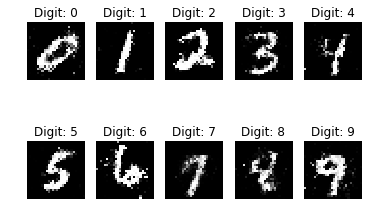

11800 [D loss: 0.700067, acc.: 59.38%] [G loss: 0.711312]
(10, 28, 28, 1)


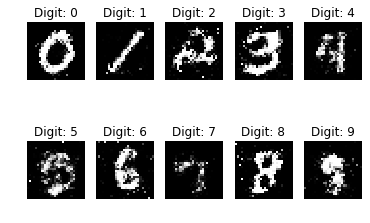

11900 [D loss: 0.626361, acc.: 65.62%] [G loss: 0.828823]
(10, 28, 28, 1)


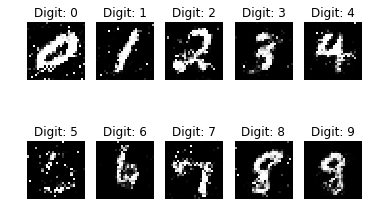

12000 [D loss: 0.603090, acc.: 76.56%] [G loss: 0.842241]
(10, 28, 28, 1)


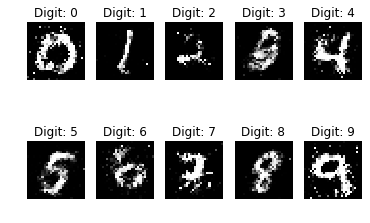

12100 [D loss: 0.679670, acc.: 51.56%] [G loss: 0.796181]
(10, 28, 28, 1)


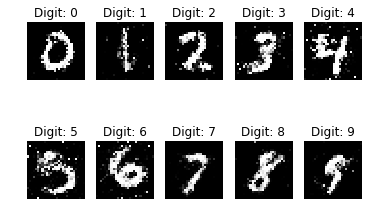

12200 [D loss: 0.688657, acc.: 57.81%] [G loss: 0.756333]
(10, 28, 28, 1)


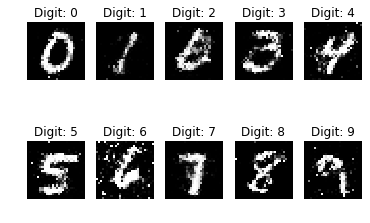

12300 [D loss: 0.660607, acc.: 59.38%] [G loss: 0.762862]
(10, 28, 28, 1)


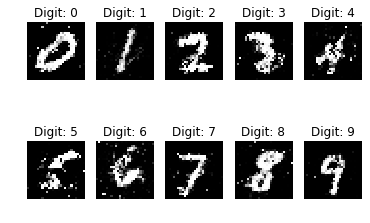

12400 [D loss: 0.683035, acc.: 53.12%] [G loss: 0.787626]
(10, 28, 28, 1)


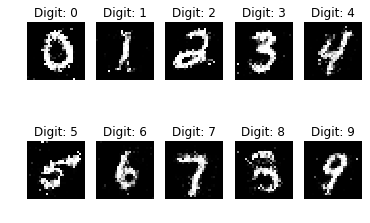

12500 [D loss: 0.628762, acc.: 62.50%] [G loss: 0.760309]
(10, 28, 28, 1)


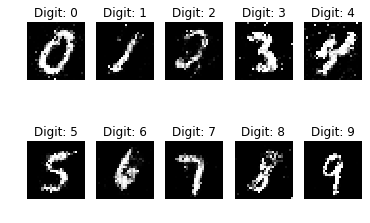

12600 [D loss: 0.699985, acc.: 51.56%] [G loss: 0.837956]
(10, 28, 28, 1)


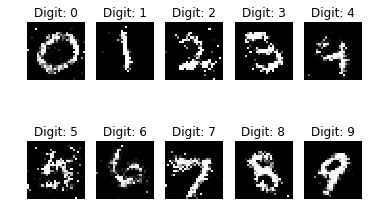

12700 [D loss: 0.659716, acc.: 53.12%] [G loss: 0.762126]
(10, 28, 28, 1)


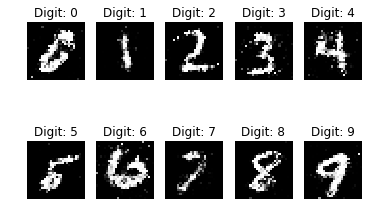

12800 [D loss: 0.627265, acc.: 65.62%] [G loss: 0.843776]
(10, 28, 28, 1)


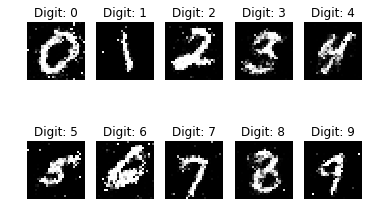

12900 [D loss: 0.655978, acc.: 60.94%] [G loss: 0.768526]
(10, 28, 28, 1)


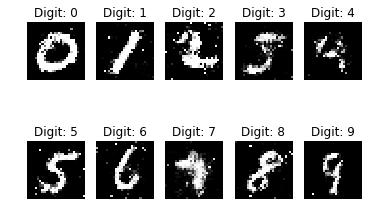

13000 [D loss: 0.681590, acc.: 53.12%] [G loss: 0.831506]
(10, 28, 28, 1)


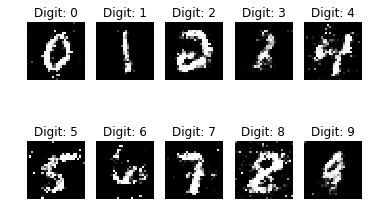

13100 [D loss: 0.696988, acc.: 59.38%] [G loss: 0.864125]
(10, 28, 28, 1)


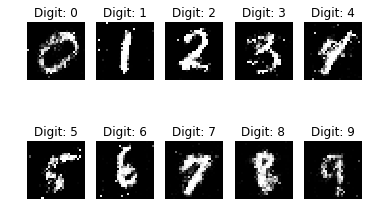

13200 [D loss: 0.684021, acc.: 64.06%] [G loss: 0.800891]
(10, 28, 28, 1)


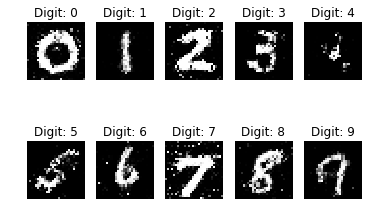

13300 [D loss: 0.653082, acc.: 60.94%] [G loss: 0.767838]
(10, 28, 28, 1)


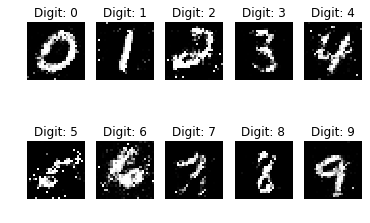

13400 [D loss: 0.727441, acc.: 46.88%] [G loss: 0.799706]
(10, 28, 28, 1)


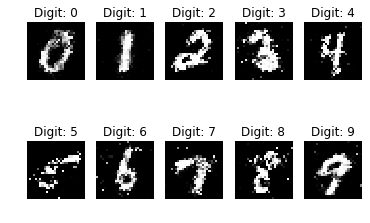

13500 [D loss: 0.675356, acc.: 54.69%] [G loss: 0.822083]
(10, 28, 28, 1)


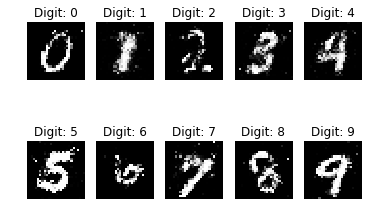

13600 [D loss: 0.645937, acc.: 57.81%] [G loss: 0.859246]
(10, 28, 28, 1)


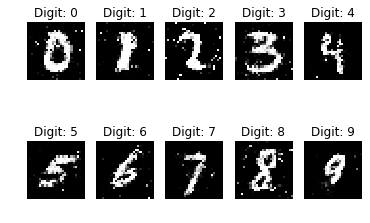

13700 [D loss: 0.628016, acc.: 62.50%] [G loss: 0.887979]
(10, 28, 28, 1)


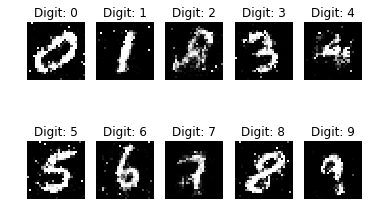

13800 [D loss: 0.643334, acc.: 65.62%] [G loss: 0.817775]
(10, 28, 28, 1)


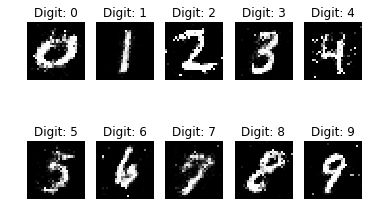

13900 [D loss: 0.702923, acc.: 59.38%] [G loss: 0.789608]
(10, 28, 28, 1)


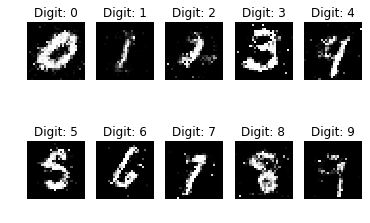

14000 [D loss: 0.637128, acc.: 57.81%] [G loss: 0.781115]
(10, 28, 28, 1)


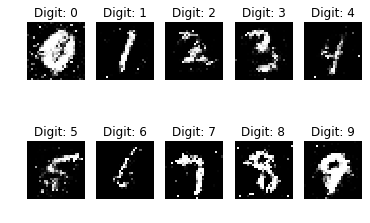

14100 [D loss: 0.642787, acc.: 59.38%] [G loss: 0.859892]
(10, 28, 28, 1)


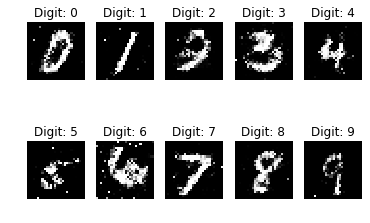

14200 [D loss: 0.664860, acc.: 56.25%] [G loss: 0.803374]
(10, 28, 28, 1)


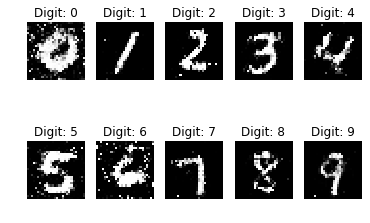

14300 [D loss: 0.738112, acc.: 50.00%] [G loss: 0.790474]
(10, 28, 28, 1)


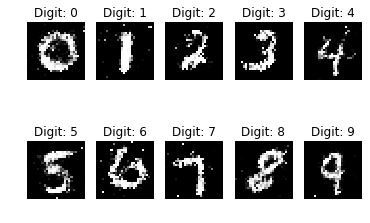

14400 [D loss: 0.711372, acc.: 50.00%] [G loss: 0.722465]
(10, 28, 28, 1)


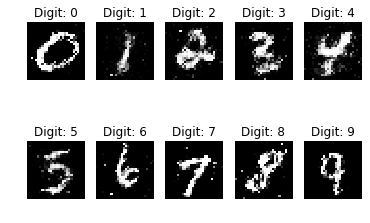

14500 [D loss: 0.625615, acc.: 65.62%] [G loss: 0.707913]
(10, 28, 28, 1)


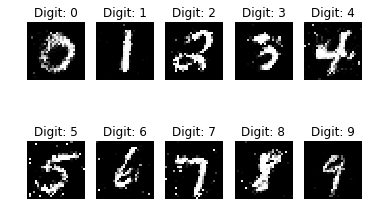

14600 [D loss: 0.681739, acc.: 54.69%] [G loss: 0.806066]
(10, 28, 28, 1)


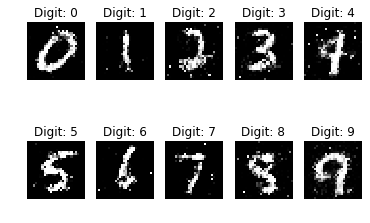

14700 [D loss: 0.656711, acc.: 62.50%] [G loss: 0.891212]
(10, 28, 28, 1)


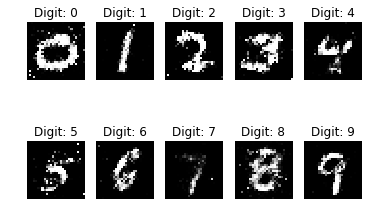

14800 [D loss: 0.632554, acc.: 64.06%] [G loss: 0.834263]
(10, 28, 28, 1)


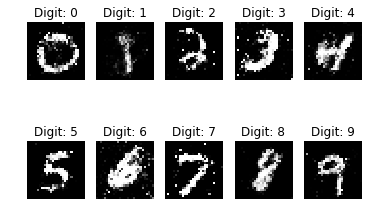

14900 [D loss: 0.636384, acc.: 67.19%] [G loss: 0.831231]
(10, 28, 28, 1)


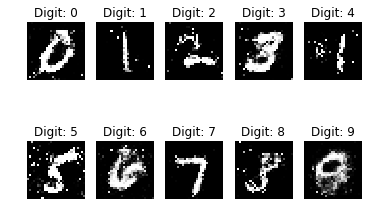

15000 [D loss: 0.627841, acc.: 64.06%] [G loss: 0.794503]
(10, 28, 28, 1)


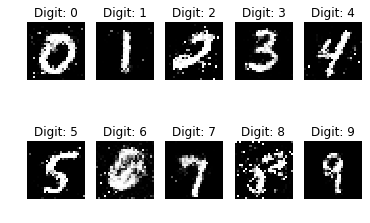

15100 [D loss: 0.680032, acc.: 56.25%] [G loss: 0.882268]
(10, 28, 28, 1)


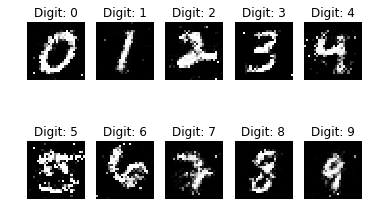

15200 [D loss: 0.745733, acc.: 51.56%] [G loss: 0.870437]
(10, 28, 28, 1)


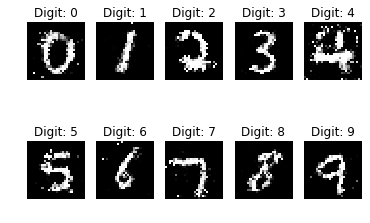

15300 [D loss: 0.617565, acc.: 65.62%] [G loss: 0.803039]
(10, 28, 28, 1)


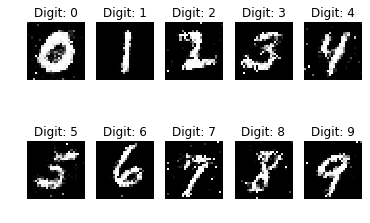

15400 [D loss: 0.617158, acc.: 57.81%] [G loss: 0.793541]
(10, 28, 28, 1)


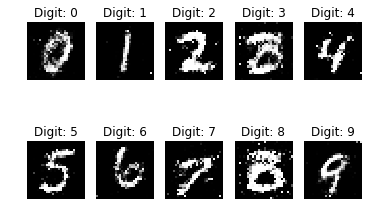

15500 [D loss: 0.614663, acc.: 67.19%] [G loss: 0.806777]
(10, 28, 28, 1)


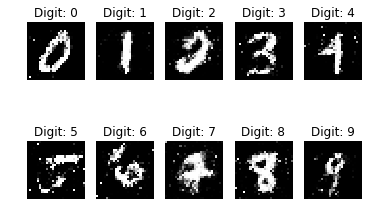

15600 [D loss: 0.703638, acc.: 51.56%] [G loss: 0.768449]
(10, 28, 28, 1)


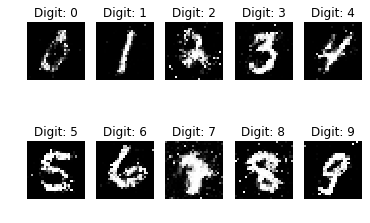

15700 [D loss: 0.687634, acc.: 56.25%] [G loss: 0.800109]
(10, 28, 28, 1)


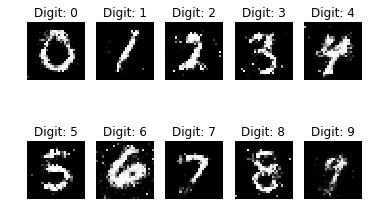

15800 [D loss: 0.652913, acc.: 64.06%] [G loss: 0.823663]
(10, 28, 28, 1)


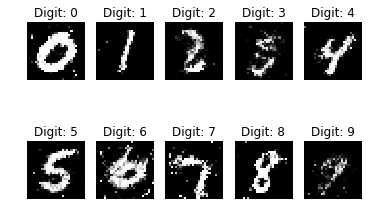

15900 [D loss: 0.651718, acc.: 54.69%] [G loss: 0.825473]
(10, 28, 28, 1)


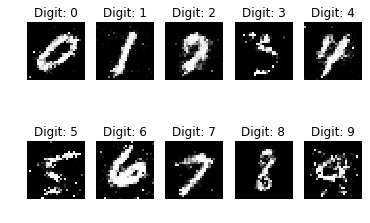

16000 [D loss: 0.665064, acc.: 53.12%] [G loss: 0.774691]
(10, 28, 28, 1)


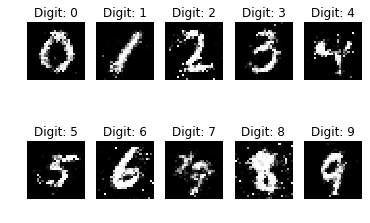

16100 [D loss: 0.688312, acc.: 50.00%] [G loss: 0.790829]
(10, 28, 28, 1)


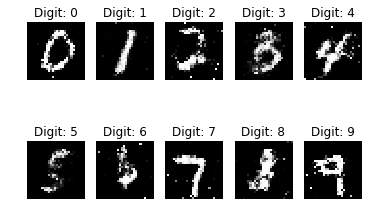

16200 [D loss: 0.694528, acc.: 54.69%] [G loss: 0.719724]
(10, 28, 28, 1)


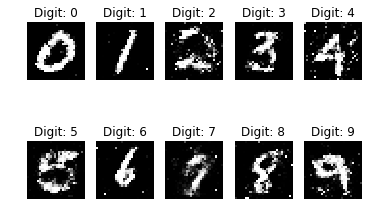

16300 [D loss: 0.669700, acc.: 54.69%] [G loss: 0.770083]
(10, 28, 28, 1)


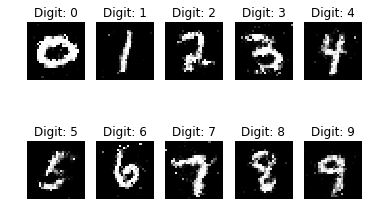

16400 [D loss: 0.693345, acc.: 48.44%] [G loss: 0.794515]
(10, 28, 28, 1)


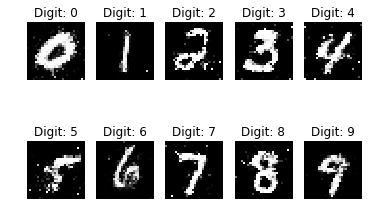

16500 [D loss: 0.707856, acc.: 54.69%] [G loss: 0.809880]
(10, 28, 28, 1)


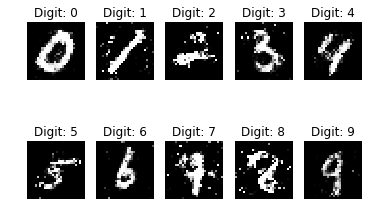

16600 [D loss: 0.678698, acc.: 46.88%] [G loss: 0.792548]
(10, 28, 28, 1)


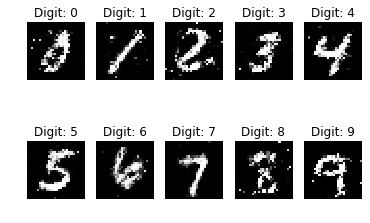

16700 [D loss: 0.663305, acc.: 51.56%] [G loss: 0.707668]
(10, 28, 28, 1)


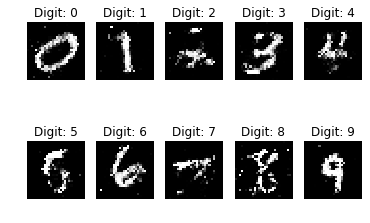

16800 [D loss: 0.669204, acc.: 57.81%] [G loss: 0.800460]
(10, 28, 28, 1)


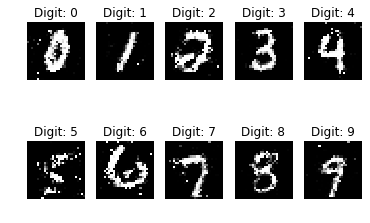

16900 [D loss: 0.663646, acc.: 54.69%] [G loss: 0.826380]
(10, 28, 28, 1)


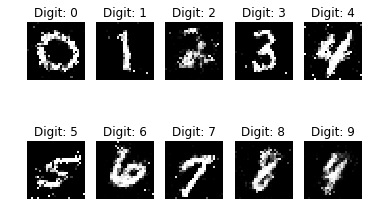

17000 [D loss: 0.621000, acc.: 62.50%] [G loss: 0.823883]
(10, 28, 28, 1)


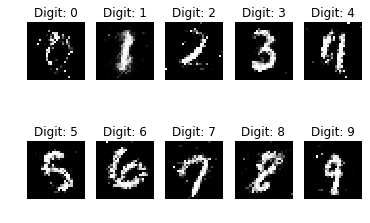

17100 [D loss: 0.704979, acc.: 45.31%] [G loss: 0.796136]
(10, 28, 28, 1)


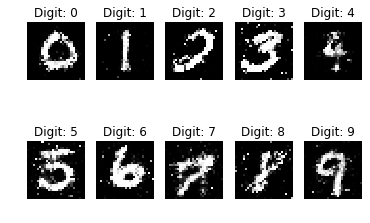

17200 [D loss: 0.677406, acc.: 65.62%] [G loss: 0.808700]
(10, 28, 28, 1)


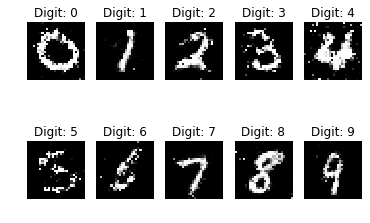

17300 [D loss: 0.722138, acc.: 48.44%] [G loss: 0.770359]
(10, 28, 28, 1)


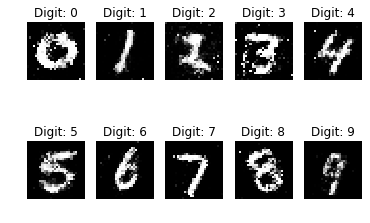

17400 [D loss: 0.658608, acc.: 59.38%] [G loss: 0.827082]
(10, 28, 28, 1)


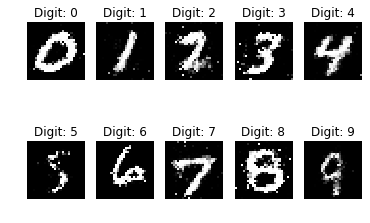

17500 [D loss: 0.702656, acc.: 50.00%] [G loss: 0.777658]
(10, 28, 28, 1)


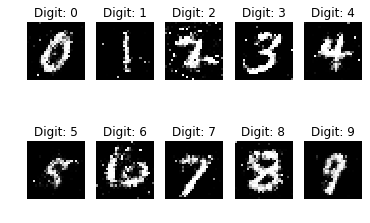

17600 [D loss: 0.667569, acc.: 60.94%] [G loss: 0.764866]
(10, 28, 28, 1)


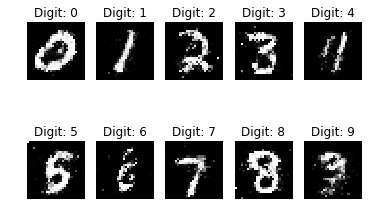

17700 [D loss: 0.642285, acc.: 59.38%] [G loss: 0.886747]
(10, 28, 28, 1)


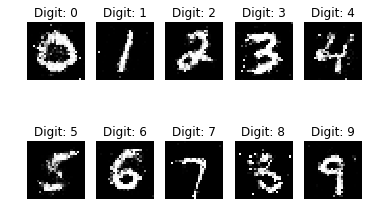

17800 [D loss: 0.684554, acc.: 56.25%] [G loss: 0.831033]
(10, 28, 28, 1)


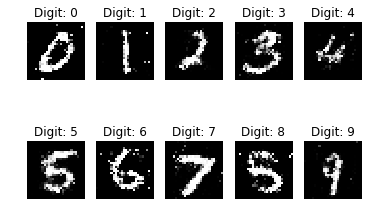

17900 [D loss: 0.644094, acc.: 62.50%] [G loss: 0.951372]
(10, 28, 28, 1)


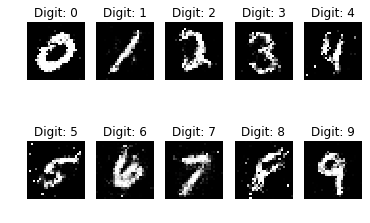

18000 [D loss: 0.689590, acc.: 54.69%] [G loss: 0.876425]
(10, 28, 28, 1)


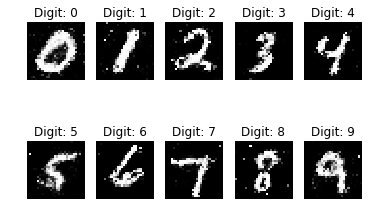

18100 [D loss: 0.684269, acc.: 53.12%] [G loss: 0.775693]
(10, 28, 28, 1)


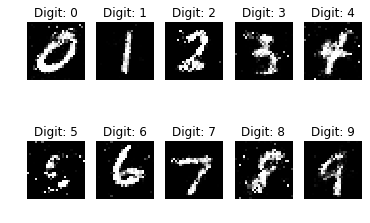

18200 [D loss: 0.636701, acc.: 65.62%] [G loss: 0.796997]
(10, 28, 28, 1)


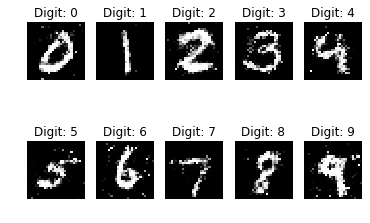

18300 [D loss: 0.676578, acc.: 54.69%] [G loss: 0.813499]
(10, 28, 28, 1)


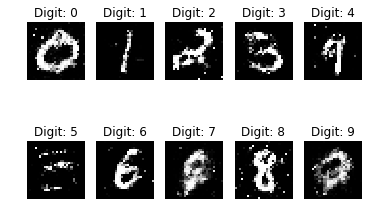

18400 [D loss: 0.708385, acc.: 50.00%] [G loss: 0.837735]
(10, 28, 28, 1)


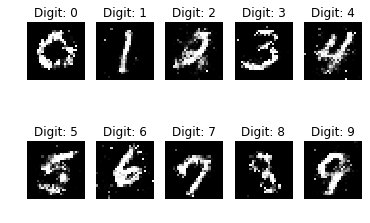

18500 [D loss: 0.671041, acc.: 60.94%] [G loss: 0.792761]
(10, 28, 28, 1)


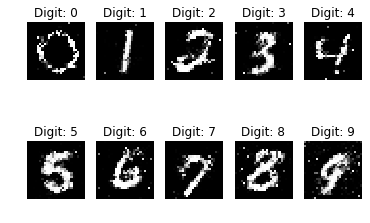

18600 [D loss: 0.673306, acc.: 60.94%] [G loss: 0.830133]
(10, 28, 28, 1)


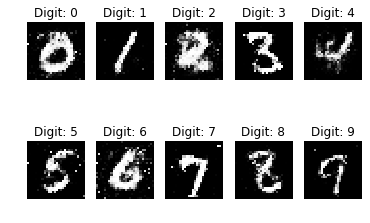

18700 [D loss: 0.668431, acc.: 56.25%] [G loss: 0.824745]
(10, 28, 28, 1)


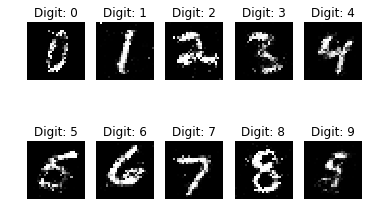

18800 [D loss: 0.653051, acc.: 57.81%] [G loss: 0.788098]
(10, 28, 28, 1)


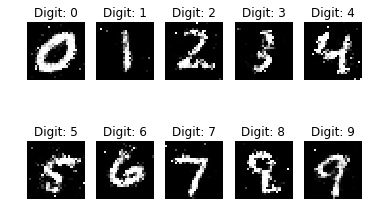

18900 [D loss: 0.678712, acc.: 54.69%] [G loss: 0.833187]
(10, 28, 28, 1)


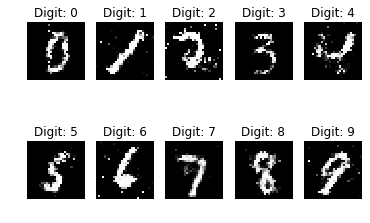

19000 [D loss: 0.684069, acc.: 45.31%] [G loss: 0.812109]
(10, 28, 28, 1)


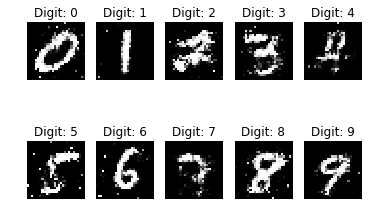

19100 [D loss: 0.692421, acc.: 48.44%] [G loss: 0.729351]
(10, 28, 28, 1)


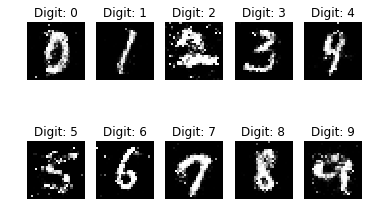

19200 [D loss: 0.652855, acc.: 60.94%] [G loss: 0.810950]
(10, 28, 28, 1)


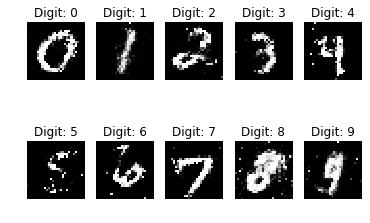

19300 [D loss: 0.655894, acc.: 64.06%] [G loss: 0.788390]
(10, 28, 28, 1)


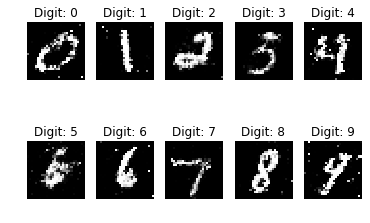

19400 [D loss: 0.629398, acc.: 64.06%] [G loss: 0.864969]
(10, 28, 28, 1)


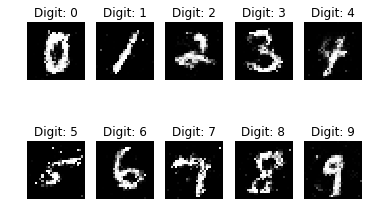

19500 [D loss: 0.659581, acc.: 60.94%] [G loss: 0.808232]
(10, 28, 28, 1)


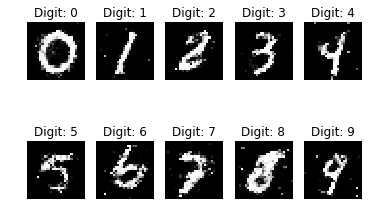

19600 [D loss: 0.697955, acc.: 57.81%] [G loss: 0.855047]
(10, 28, 28, 1)


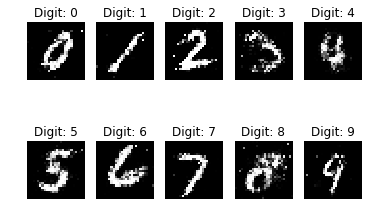

19700 [D loss: 0.653415, acc.: 62.50%] [G loss: 0.773211]
(10, 28, 28, 1)


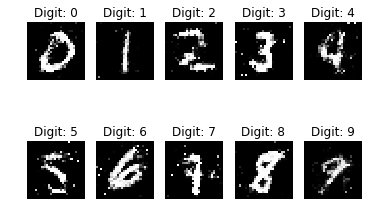

19800 [D loss: 0.656573, acc.: 54.69%] [G loss: 0.790286]
(10, 28, 28, 1)


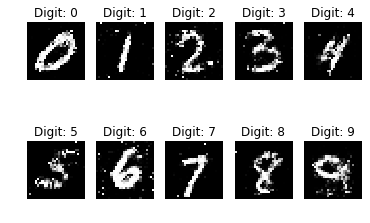

19900 [D loss: 0.648574, acc.: 53.12%] [G loss: 0.821804]
(10, 28, 28, 1)


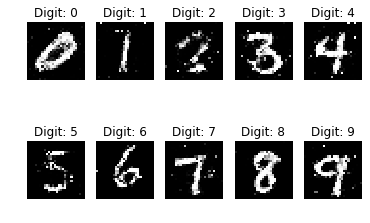

In [18]:
for step in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  
  imgs, labels = x_train[idx], y_train[idx]
  
  noise = np.random.normal(0,1,(batch_size, 100))
  
  gen_imgs = generator.predict([noise,labels])

  d_loss_real = discriminator.train_on_batch([imgs,labels],valid)
  d_loss_fake = discriminator.train_on_batch([gen_imgs,labels],fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
  
  g_loss = gan.train_on_batch([noise, sampled_labels],valid)
  
  if step%100 == 0:
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (step, d_loss[0], 100*d_loss[1], g_loss))
    sample_images(step)